## 코더의 소회      
**날씨 :** 오늘의 학습 < >했습니다. [☀️⛅☁️🌧️🌩️⛈️]   

**배운점 :**   

**아쉬운점 :**   

**느낀점 :**   

(참고 : https://github.com/Annyong2/AIFFEL_quest_rs/tree/master/GoingDeeper/Gdr09)    


## 전체 코드 실행 플로우 (목차) :     
✅ Prep A. Import Library & Dataset   
✅ Prep B. EDA & Preprocessing   
✅ Train 1. Supervised Fine-Tuning (instruction dataset: kogpt-2)   
✅ Train 2. Reward Model   
✅ Train 3. Proximal Policy Optization   

---   
# ✅Prep A. Import Library & Dataset   
---


In [4]:
pip install git+https://github.com/ssut/py-hanspell.git

  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-o7nkai6s
  Running command git clone --filter=blob:none -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-o7nkai6s
  Resolved https://github.com/ssut/py-hanspell.git to commit fdc6ca50c19f1c85971437a072d89d4e5ce024b8
  Preparing metadata (setup.py) ... done
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4844 sha256=740159d813a94410144df2ddfa04b51541cc001c9c952070bc2cb6bcda1db920
  Stored in directory: /tmp/pip-ephem-wheel-cache-74pt0eyd/wheels/94/bc/ef/2cb90c305d609f8086489e7e1bd69f21e955118f26938609b7
Successfully built py-hanspell
Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
import transformers

print("Torch version:{}".format(torch.__version__)) # Torch version:1.12.1
print("Cuda version: {}".format(torch.version.cuda)) # Cuda version: 11.3
print("transformers version: {}".format(transformers.__version__)) # transformers 4.28.0
print("GPU 사용 가능여부: {}".format(torch.cuda.is_available()))

Torch version:1.12.1
Cuda version: 11.3
transformers version: 4.28.0
GPU 사용 가능여부: True


In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import multiprocessing

# os 모듈 수
cpu_count_os = os.cpu_count()
print(f"CPU 코어 수 (os): {cpu_count_os}")

# multiprocessing 모듈 수
cpu_count_mp = multiprocessing.cpu_count()
print(f"CPU 코어 수 (multiprocessing): {cpu_count_mp}")

CPU 코어 수 (os): 4
CPU 코어 수 (multiprocessing): 4


In [7]:
# 데이터 처리 및 환경 설정
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
import pandas as pd
import numpy as np
from copy import deepcopy, copy
import logging
import json
from dataclasses import dataclass
from typing import Optional
import loralib as lora

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm  # 폰트 설정

# from pykospacing import Spacing
from hanspell import spell_checker

# Supervised Fine-Tuning
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, pipeline
from datasets import load_dataset

#### PATH

In [8]:
# model_name = 'skt/kogpt2-base-v2'
model_save_path_1 = '/aiffel/KoChatGPT/output_1_SFT' 
model_save_path_2 = 'aiffel/KoChatGPT/output_2_RM'
model_save_path_3 = 'aiffel/KoChatGPT/output_3_PPO'

data_path_1_SFT = '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl'
data_path_2_RM  = '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl'
data_path_3_PPO = '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl'

output_dir = '/aiffel/KoChatGPT/test'
logging_dir_1 = '/aiffel/KoChatGPT/logs/SFT_logs'
logging_dir_2 = '/aiffel/KoChatGPT/logs/RM_logs'
logging_dir_3 = '/aiffel/KoChatGPT/logs/PPO_logs'

#### Setting Model , Tokenizer, Device 

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# 허깅페이스의 transformers모델과 토크나이저 정하기
model_name = "skt/kogpt2-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


---   
# ✅Prep B. EDA & Preprocessing   
---


## EDA

#### EDA : 데이터셋별 길이 확인 (max_length정하기 위하여 봄)

In [10]:
# 데이터 경로 설정
data_paths = {
    "SFT": '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl',
    "RM": '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl',
    "PPO": '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl'
}

In [11]:
# 데이터 길이를 계산하고 저장할 딕셔너리
lengths = {"SFT": [], "RM": [], "PPO": []}

# 데이터 길이 계산 함수
def calculate_lengths(data_path, data_type):
    with open(data_path, "r", encoding='utf-8-sig') as json_file:
        list_data_dict = json.load(json_file)

    for data in list_data_dict:
        if data_type == "SFT":
            # SFT는 prompt와 completion의 길이 합을 계산
            text = data['prompt'] + " " + data['completion']
        elif data_type == "RM":
            # RM은 prompt와 completion들 중 하나의 합을 계산
            text = data['prompt'] + " " + data['completion_0']
        elif data_type == "PPO":
            # PPO는 prompt만 사용
            text = data['prompt']
        
        tokenized_text = tokenizer(text, return_tensors='pt')
        lengths[data_type].append(tokenized_text['input_ids'].shape[1])  # 토큰 길이 추가

# 80%를 포함하는 토큰 길이 계산 함수 
def calculate_80_percentile_length(data, text_keys, tokenizer):
    """
    전체 데이터의 80%를 포함하는 토큰 길이를 계산하는 함수.
    
    Args:
        data (list): 데이터 리스트. 각 항목은 딕셔너리 형태여야 하며, text_keys를 포함해야 함.
        text_keys (list): 텍스트가 포함된 키 리스트 (예: ['completion_0', 'completion_1', 'completion_2'] 등)
        tokenizer (transformers.AutoTokenizer): 텍스트 토크나이저 객체

    Returns:
        int: 전체 데이터의 80%를 포함하는 토큰 길이
    """
    lengths = []
    for item in data:
        for key in text_keys:
            if key in item:  # 키가 존재하는 경우에만 처리
                text = item[key]
                tokenized_text = tokenizer(text, return_tensors='pt')
                lengths.append(tokenized_text['input_ids'].shape[1])  # 토큰 길이 저장

    percentile_80_length = int(np.percentile(lengths, 80))
    return percentile_80_length

#### 데이터셋별 길이보기

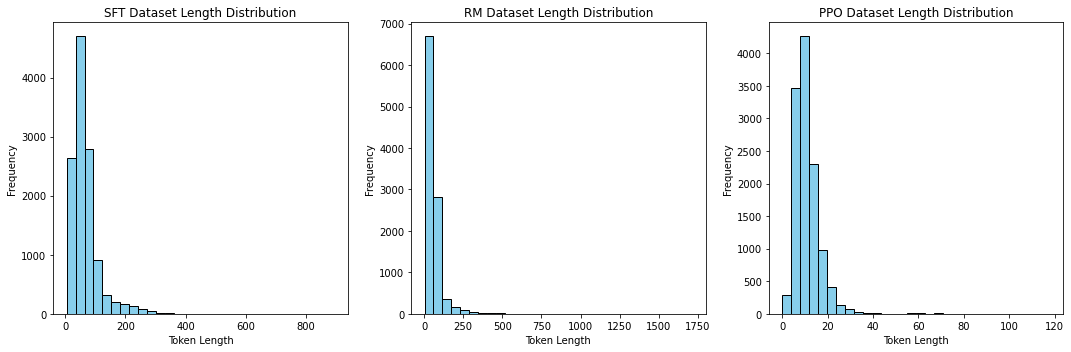

In [12]:
# 각 데이터셋의 길이 계산
for data_type, data_path in data_paths.items():
    calculate_lengths(data_path, data_type)

# 시각화
plt.figure(figsize=(15, 5))
for i, (data_type, length_data) in enumerate(lengths.items()):
    plt.subplot(1, 3, i + 1)
    plt.hist(length_data, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'{data_type} Dataset Length Distribution')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [13]:
# 데이터셋을 순차적으로 로드, 처리, 메모리 해제
for data_type, data_path in data_paths.items():
    with open(data_path, "r", encoding='utf-8-sig') as json_file:
        list_data_dict = json.load(json_file)

    # 데이터셋별 key 설정
    if data_type == "SFT":
        text_keys = ['completion']
    elif data_type == "RM":
        text_keys = ['completion_0', 'completion_1', 'completion_2']
    elif data_type == "PPO":
        text_keys = ['prompt']
    
    # 80%를 포함하는 토큰 길이 계산 및 출력
    percentile_80_length = calculate_80_percentile_length(list_data_dict, text_keys, tokenizer)
    print(f"{data_type} 데이터셋의 80%를 포함하는 Token Length: {percentile_80_length}")
    print(list_data_dict[50],"\n",list_data_dict[80],"\n",list_data_dict[97],"\n",list_data_dict[270],"\n",list_data_dict[410])
    print()
    
    # 메모리 해제
    del list_data_dict


SFT 데이터셋의 80%를 포함하는 Token Length: 75
{'prompt': '동거 8년 환승이별.', 'completion': "'8 years of living together, transfer separation.", 'tokens': 31} 
 {'prompt': '새벽 3시', 'completion': "'저는 AI 챗봇이므로 시간 개념이 없습니다. 어떤 도움이 필요하신가요?", 'tokens': 55} 
 {'prompt': '헤어진지 두달 늘 만났던 장소를. 난 지나다니고', 'completion': "'그리움으로 가득 찬 마음을 가지고 헤어진 지 두 달이 지난 지금, 난 그 장소를 지나다니며 끝없는 추억들이 떠오른다. 그곳은 우리가 자주 만났던 곳이었기에 언제나 그리움이 가득한 곳이었다. 하지만 이젠 그곳을 지나가면서도 더 이상 그리움에 빠져 살아갈 순 없다는 것을 깨닫게 되었다. 이젠 새로운 시작을 위해 앞으로 나아가야 한다는 것을. 그리고 그 곳에서 만났던 너에 대한 그리움도 조금씩 사라져가고 있다. 이젠 지난 일로 여길 수 있게 되었기 때문이다. \\n하지만 그곳에서 만났던 추억은 언제나 나와 함께 살아남을 것이다. 나없이도 그곳은 그 자체로 아름다운 곳이기 때문이다. 그리고 난 언제나 그곳을 지나가면서 그 나름대로의 아름다움을 즐길 수 있을 것이다. 이젠 그곳에서 우리가 만났었다는 사실에 대해 생각해도 그리운 감정이 아니라, 예전 처럼 가벼운 마음으로 그냥 그게 그랬구나 정도로 생각할 수 있게 되었다. 그리고 이젠 나는 앞으로 나아가며 새로운 경험들을 쌓고 새로운 인연들과 만나려고 노력할 것이다.", 'tokens': 516} 
 {'prompt': '1차 다면 면접형태의 성직심사를 마치면 어떤 자격으로 받아들여지는가?', 'completion': "'1차 다면 면접형태의 성직심사를 통해 합격자는 일반적으로 예비신부, 예비신부지원자, 단순한 신자 등 다양한 자격으로 받아들여질 수 있습니다. 이는 각 교회나 종교단체의 입장과 관행에

In [14]:
max_lengths = {
    "SFT": 150,
    "RM": 100,
    "PPO": 20
}

## Preprocessing  

**<공통 전처리>**   
[] 맞춤법 및 띄어쓰기 교정   
[] 불필요한 문자 제거   
[] 토큰 길이(Token Length) 조정    

**<데이터셋별 특이 전처리>**   
[] Reward Model : 다국어 문장 필터링    

#### preprocess_data 함수 정의

In [15]:
# 공통1) 맞춤법 및 띄어쓰기 교정 함수
def correct_text(text):
    checked = spell_checker.check(text)
    return checked.checked  # 교정된 텍스트 반환

# 공통2) 불필요한 문자 제거
def remove_unwanted_chars(text):
    return re.sub(r"[^\w\s가-힣.,!?]", "", text)

# 특이1) 다국어 필터링 함수 (한글과 영어 이외의 문자 제거)
def filter_non_kr_en(text):
    return re.sub(r"[^가-힣a-zA-Z0-9\s.,!?]", "", text)



# 전처리 함수 (공통1,2,3 + 특이)
def preprocess_data(data, data_type):
    max_length = max_lengths[data_type]
    preprocessed_data = []

    for item in data:
        # 데이터셋에 따라 텍스트 설정
        if data_type == "SFT":
            text = item['prompt'] + " " + item['completion']
            texts = [text]
        elif data_type == "RM":
            # 모든 completion 항목을 개별적으로 전처리
            texts = [
                item['prompt'] + " " + item['completion_0'],
                item['prompt'] + " " + item['completion_1'],
                item['prompt'] + " " + item['completion_2']
            ]
        elif data_type == "PPO":
            text = item['prompt']
            texts = [text]

        # 각 텍스트에 대해 전처리 수행
        for text in texts:
            # 공통 전처리: 불필요한 문자 제거, 맞춤법 및 띄어쓰기 교정
            text = remove_unwanted_chars(text)
            text = correct_text(text)
            
            # Reward Model의 다국어 문장 필터링 (RM 데이터셋에만 적용)
            if data_type == "RM":
                text = filter_non_kr_en(text)
            
            # 토큰화 및 토큰 길이 조정
            tokenized_text = tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
            preprocessed_data.append(tokenized_text)

    return preprocessed_data



In [ ]:
'''# 각 데이터셋에 대해 전처리 수행
for data_type, data_path in data_paths.items():
    with open(data_path, "r", encoding='utf-8-sig') as json_file:
        list_data_dict = json.load(json_file)
    
    preprocessed_data = preprocess_data(list_data_dict, data_type)
    print(f"{data_type} 데이터셋의 전처리 완료, 샘플 수: {len(preprocessed_data)}")'''

---   
# ✅Train 1. Supervised Fine-Tuning      
---
(instruction dataset: kogpt-2)   

In [16]:
data_path_1 = data_paths["SFT"]

with open(data_path_1, "r", encoding='utf-8-sig') as json_file:
    list_data_dict_1 = json.load(json_file)

preprocessed_data_1 = preprocess_data(list_data_dict_1, data_type)
print(f"{data_type} 데이터셋의 전처리 완료, 샘플 수: {len(preprocessed_data_1)}")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:6                                                                                    │
│                                                                                                  │
│   3 with open(data_path_1, "r", encoding='utf-8-sig') as json_file:                              │
│   4 │   list_data_dict_1 = json.load(json_file)                                                  │
│   5                                                                                              │
│ ❱ 6 preprocessed_data_1 = preprocess_data(list_data_dict_1, data_type)                           │
│   7 print(f"{data_type} 데이터셋의 전처리 완료, 샘플 수: {len(preprocessed_data_1)}")            │
│   8                                                                                              │
│                                                                                                  │
│ in preprocess_data:41                                                                            │
│                                                                                                  │
│   38 │   │   for text in texts:                                                                  │
│   39 │   │   │   # 공통 전처리: 불필요한 문자 제거, 맞춤법 및 띄어쓰기 교정                      │
│   40 │   │   │   text = remove_unwanted_chars(text)                                              │
│ ❱ 41 │   │   │   text = correct_text(text)                                                       │
│   42 │   │   │                                                                                   │
│   43 │   │   │   # Reward Model의 다국어 문장 필터링 (RM 데이터셋에만 적용)                      │
│   44 │   │   │   if data_type == "RM":                                                           │
│                                                                                                  │
│ in correct_text:3                                                                                │
│                                                                                                  │
│    1 # 공통1) 맞춤법 및 띄어쓰기 교정 함수                                                       │
│    2 def correct_text(text):                                                                     │
│ ❱  3 │   checked = spell_checker.check(text)                                                     │
│    4 │   return checked.checked  # 교정된 텍스트 반환                                            │
│    5                                                                                             │
│    6 # 공통2) 불필요한 문자 제거                                                                 │
│                                                                                                  │
│ /opt/conda/lib/python3.9/site-packages/hanspell/spell_checker.py:62 in check                     │
│                                                                                                  │
│    59 │   passed_time = time.time() - start_time                                                 │
│    60 │                                                                                          │
│    61 │   data = json.loads(r.text)                                                              │
│ ❱  62 │   html = data['message']['result']['html']                                               │
│    63 │   result = {                                                                             │
│    64 │   │   'result': True,                                                                    │
│    65 │   │   'original': text,                                                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'result'

In [ ]:
# SFT 데이터셋 클래스 정의
class SFT_dataset(Dataset):

    def __init__(self, preprocessed_data: list, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        self.input_ids = [item["input_ids"].squeeze() for item in preprocessed_data]
        self.labels = copy.deepcopy(self.input_ids)
        for label in self.labels:
            label[:len(label)] = -100

        logging.warning("Loading data done!!: %d" % (len(self.labels)))

    def __len__(self):
        return len(self.input_ids)
        
    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])



In [ ]:
# 데이터셋 인스턴스 생성
train_dataset = SFT_dataset(preprocessed_data_1, tokenizer)

In [ ]:
# 학습 파라미터 설정
training_args = TrainingArguments(
    output_dir=output_dir, 
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=5,
    prediction_loss_only=True,
    fp16=True,
    logging_dir=logging_dir_1,
    logging_steps=5,    
)

# Trainer 정의
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset
)

# 학습 시작
trainer.train()
model.save_pretrained(model_save_path_1)

---   
# ✅Train 2. Reward Model   
---


In [ ]:
# Reward Model
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoModel, AutoConfig
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model



In [ ]:
data_path_2 = data_paths["RM"]

with open(data_path_2, "r", encoding='utf-8-sig') as json_file:
    list_data_dict_2 = json.load(json_file)

preprocessed_data_2 = preprocess_data(list_data_dict_2, data_type)
print(f"{data_type} 데이터셋의 전처리 완료, 샘플 수: {len(preprocessed_data_2)}")

In [ ]:
# Reward Dataset 정의
train_data = preprocessed_data_2[:int(len(preprocessed_data_2)*0.8)]
eval_data = preprocessed_data_2[int(len(preprocessed_data_2)*0.8):]
train_dataset = RewardDataset(train_data, tokenizer, 512)
eval_dataset = RewardDataset(eval_data, tokenizer, 512)

In [ ]:
# Reward Model 정의 및 학습
model = GPT2Model.from_pretrained(model_name)
value_head = nn.Linear(model.config.n_embd, 1)
reward_model = RewardModel(model, value_head).to(device)
trainer = RewardModelTrainer(
    model=reward_model,
    strategy=NaiveStrategy(),
    optim=Adam(reward_model.parameters(), lr=5e-5),
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    batch_size=4,
    max_epochs=3,
    logging_dir=logging_dir_2,
    logging_steps=5
)
trainer.fit()
reward_model.save_pretrained(model_save_path_2)

---   
# ✅Train 3. Proximal Policy Optization   
---

In [ ]:
# Proximal Policy Optimization (PPO)
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoTokenizer

In [ ]:
# PPO를 위한 모델 초기화
actor = GPTActor(pretrained=model_save_path_1, lora_rank=0).to(device)
critic = GPTCritic(pretrained=model_save_path_2, lora_rank=0).to(device)
initial_model = deepcopy(actor)
reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(device)

In [ ]:
# 옵티마이저 정의
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)

# PPOTrainer 정의 및 학습
ppo_trainer = PPOTrainer(
    strategy=NaiveStrategy(),
    actor=actor,
    critic=critic,
    reward_model=reward_model,
    initial_model=initial_model,
    actor_optim=actor_optim,
    critic_optim=critic_optim,
    max_epochs=3,
    train_batch_size=8,
    tokenizer=tokenizer,
    max_length=128,
    do_sample=True,
    temperature=1.0,
    top_k=50,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    logging_dir=logging_dir_3,
    logging_steps=5
)
ppo_trainer.fit([data['prompt'] for data in list_data_dict_2], num_episodes=10, max_timesteps=3, update_timesteps=3)
actor.save_pretrained(model_save_path_3)
